# Классификатор эмоций

В этом нойтбуке создается и обучается модель для классификации эмоций по изображению лица

In [ ]:
import tensorflow as tf 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input, decode_predictions as resnet50_decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input, decode_predictions as vgg16_decode_predictions 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input, decode_predictions as xception_decode_predictions 


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from pathlib import Path

import random
import datetime as dt 
import os

## Опредление путей к данным

In [ ]:
# флаг использования Google drive как хранилища данных
USE_GOOGLE_DRIVE = True

#Корневая папка проекта
root_dir = ''

In [ ]:
#Подключаем google drive, если код будет выполняться в Colab
if USE_GOOGLE_DRIVE:
    from google.colab import drive

    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Projects/EmoDetector'
    
    import sys
    sys.path.append(root_dir)

    #скачиваем исходные данные
    import gdown
    url = 'https://drive.google.com/uc?id=1pm86O0t_0caQq3b3Qz5iNI3T77p2o-C1'
    output = 'train.zip'
    gdown.download(url, output, quiet=False)

    #распакуем архив
    !unzip -q train.zip

#if

Mounted at /content/drive


Downloading...
From: https://drive.google.com/uc?id=1pm86O0t_0caQq3b3Qz5iNI3T77p2o-C1
To: /content/train.zip
2.27GB [00:28, 78.9MB/s]


In [ ]:
import emo_utils as utils

In [ ]:
#Получаем пути к директориям и файлам проекта

paths = utils.get_paths(root_dir)

print (paths)

{'data_dir': '/content/drive/My Drive/Projects/EmoDetector/data', 'model_dir': '/content/drive/My Drive/Projects/EmoDetector/model', 'train_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/train', 'train_aug_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/train_aug', 'val_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/val', 'test_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/test_kaggle', 'class_names_path': '/content/drive/My Drive/Projects/EmoDetector/data/class_names.txt', 'best_checkpoint_path': '/content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best'}


In [ ]:
'Переопределяем локальные пути к данным для Google Colab'
if USE_GOOGLE_DRIVE:
    paths['train_data_dir'] = '/content/train'
    paths['train_aug_data_dir'] = '/content/train_aug'
    paths['val_data_dir'] = '/content/val'
#if

## Создание модели

In [ ]:
# Гиперпараметры
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NUM_CLASSES = 9
EPOCHS = 20
LEARNING_RATE=0.01

#тип базовой модели
BASE_MODEL = 'xception'
IMAGE_SIZE = 299

#Тип используемой аугментации
#0 - не используется
#1 - используется аугментация "на лету", случайным образом измененные картинки генерируются генератором в процессе обучения
#2 - используется заранее сгенерированный расширенный (аугментированный) набор изображений для обучения
AUG_TYPE = 1

#Флаг что модель будет дообучаться
RESUME_TRAINING = False
#Чекпоинт, с которого продолжиться обучение
checkpoint_path = paths['model_dir'] + '/emo_classificator_best_resnet50_e10_acc_34.h5'

In [ ]:
def create_model (p_base_model, p_num_classes = 9):
    '''
    Создание модели для классификации эмоций по картинке
    
    :argument
    p_base_model - тип базовой модели:
     resnet50
     vgg16
     xception
         
    p_num_classes - количество определяемых классов
    
    return:
    base_model- базовая модель, предназначенная для извлечения признаков с картинки
    model - модель для классификации эмоций, построенная на базовой модели
    preprocessed_input - функция для обработки входных данных для базовой модели
    decode_predictions - функция для расшифровки предсказания базовой модели
    
    '''
    
    base_model = None
    model = None
    preprocess_input = None
    decode_predictions = None
    
    if p_base_model == 'resnet50':        
        
        base_model = ResNet50(weights='imagenet')
        #отрежем последние слои
        #base_layers = tf.keras.Model([base_model.input], base_model.get_layer("avg_pool").output)
        base_layers = ResNet50(weights="imagenet",
                               input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                               include_top=False)
        
        #добавим новые слои для обучения и классификации

        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        #"заморозим" часть базовых слоев
        for layer in base_layers.layers:
            if layer.name.find('conv5_block3') == -1:
                layer.trainable = False

        
        preprocess_input = resnet50_preprocess_input
        decode_predictions = resnet50_decode_predictions
        
    #if
    if p_base_model == 'vgg16':            
             
        base_model = VGG16(weights='imagenet')
        base_layers = VGG16(weights="imagenet",
                            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                            include_top=False)
        
        #добавим новые слои для обучения и классификации
        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        
        #"заморозим" часть базовых слоев
        for layer in base_layers.layers:
            if layer.name.find('block5') == -1:
                layer.trainable = False
        
        preprocess_input = vgg16_preprocess_input
        decode_predictions = vgg16_decode_predictions
        
    #if
    
    if p_base_model == 'xception':
        
             
        base_model = Xception(weights='imagenet')
                
        base_layers = tf.keras.applications.Xception(weights="imagenet",
                                                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                 include_top=False)
    
        #добавим новые слои для обучения и классификации       
        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])

        
        #"заморозим" часть базовых слоев
        for layer in base_layers.layers:
            if layer.name.find('block14') == -1:
                layer.trainable = False
        
        preprocess_input = xception_preprocess_input
        decode_predictions = xception_decode_predictions
        
    #if
      
    return base_model, model, preprocess_input, decode_predictions

#create_model

In [ ]:
base_model, model_emo_classifier, preprocess_input, decode_predictions = create_model (p_base_model=BASE_MODEL)

model_emo_classifier.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 18441     
Total params: 20,879,921
Trainable params: 4,767,241
Non-trainable params: 16,112,680
_________________________________________________________________


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

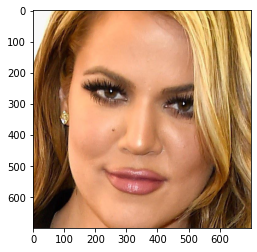

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n03676483', 'lipstick', 0.54737234), ('n04584207', 'wig', 0.13974576), ('n03404251', 'fur_coat', 0.048243053)]


In [ ]:
#Проверим базовую модель

img_path = paths['test_data_dir'] + '/4999.jpg'

#Отобразим картинку
plt.imshow(mpimg.imread(img_path))
plt.show()

x = utils.preprocess_image(img_path, (IMAGE_SIZE, IMAGE_SIZE), preprocess_input)

preds = base_model.predict(x)

#print(preds)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [ ]:
# Создадим генератор картинок для обучения модели

if AUG_TYPE < 2:

    if AUG_TYPE == 0:
        image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                       validation_split = VALIDATION_SPLIT)
    
    elif AUG_TYPE == 1:
        image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                       validation_split = VALIDATION_SPLIT,
                                       horizontal_flip=True,
                                       zoom_range=0.2,
                                       height_shift_range=0.2,
                                       width_shift_range=0.2,
                                       rotation_range=15)
    
    train_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                                     class_mode= 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                     subset = 'training')

    val_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                                   class_mode= 'categorical', 
                                                   batch_size = BATCH_SIZE, 
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   subset = 'validation',
                                                   shuffle = False)

#if

elif AUG_TYPE == 2:
    image_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
    
    train_generator = image_gen.flow_from_directory (directory= paths['train_aug_data_dir'],
                                                     class_mode= 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE))

    val_generator = image_gen.flow_from_directory (directory= paths['val_data_dir'],
                                                   class_mode= 'categorical', 
                                                   batch_size = BATCH_SIZE, 
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                    shuffle = False)
#elif
    

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


In [ ]:
# Сохраним список классов, чтобы можно было их в последствии декодировать

classes_names = ''
for key in train_generator.class_indices.keys():
    if classes_names == '': 
        classes_names = key
    else:
        classes_names = classes_names + ',' + key

with open(paths['class_names_path'], 'w') as output:
    output.write(classes_names)

In [ ]:
aug = ''
if AUG_TYPE > 0:
    aug = '_aug'+str(AUG_TYPE)

if not RESUME_TRAINING:
    checkpoint_path = paths['best_checkpoint_path'] \
                      +'_'+ dt.datetime.now().strftime ('%y%m%d%H%M%S') \
                      +'_'+ BASE_MODEL \
                      + '_e'+ str(EPOCHS) \
                      + aug +'.h5'

    #скомпилируем модель
    model_emo_classifier.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9),
                                 loss= 'categorical_crossentropy',
                                 metrics= ['accuracy'])

#    model_emo_classifier.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#                                 loss= 'categorical_crossentropy',
#                                 metrics= ['accuracy'])
#if

else:
    # Загрузим модель
    model_emo_classifier = tf.keras.models.load_model(checkpoint_path)
      
    checkpoint_path =  checkpoint_path.replace('.h5', '_e' + str(EPOCHS) + '.h5')
#else    


#Создаем объект для сохранения модели во время обучения
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor= 'val_accuracy',
                                                verbose= 1, 
                                                save_best_only= True, 
                                                mode='max')

In [ ]:
# Обучение модели

history = model_emo_classifier.fit(train_generator,
                                   validation_data = val_generator,
                                   epochs = EPOCHS,
                                   callbacks = [checkpoint])

Epoch 1/20
1252/1252 [==============================] - 1269s 1s/step - loss: 1.9525 - accuracy: 0.2761 - val_loss: 1.7183 - val_accuracy: 0.3744

Epoch 00001: val_accuracy improved from -inf to 0.37444, saving model to /content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best_210106100147_xception_e20_aug1.h5
Epoch 2/20
1252/1252 [==============================] - 1269s 1s/step - loss: 1.6825 - accuracy: 0.3856 - val_loss: 1.7330 - val_accuracy: 0.3767

Epoch 00002: val_accuracy improved from 0.37444 to 0.37674, saving model to /content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best_210106100147_xception_e20_aug1.h5
Epoch 3/20
1252/1252 [==============================] - 1295s 1s/step - loss: 1.5926 - accuracy: 0.4234 - val_loss: 1.6309 - val_accuracy: 0.4053

Epoch 00003: val_accuracy improved from 0.37674 to 0.40532, saving model to /content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best_210106100147_xception_e20_aug1.h5
Epoch 4/20

In [ ]:
history.history

{'accuracy': [0.32428380846977234,
  0.3940158486366272,
  0.42066484689712524,
  0.44102001190185547,
  0.45745399594306946,
  0.472913920879364,
  0.48375335335731506,
  0.4955168664455414,
  0.5109767913818359,
  0.5207672715187073,
  0.5368515849113464,
  0.5458428263664246,
  0.5613027215003967,
  0.568745493888855,
  0.5857539176940918,
  0.5990908741950989,
  0.607632577419281,
  0.6262643933296204,
  0.6357301473617554,
  0.6454956531524658],
 'loss': [1.841778039932251,
  1.6660740375518799,
  1.5906455516815186,
  1.5408375263214111,
  1.4947481155395508,
  1.4629969596862793,
  1.4265022277832031,
  1.395066499710083,
  1.3552945852279663,
  1.3241668939590454,
  1.2920039892196655,
  1.258981466293335,
  1.219634771347046,
  1.1939927339553833,
  1.1549662351608276,
  1.121606469154358,
  1.091475009918213,
  1.047960877418518,
  1.0230357646942139,
  0.9912188053131104],
 'val_accuracy': [0.3744378983974457,
  0.37673628330230713,
  0.4053162932395935,
  0.4116118848323822

In [ ]:
#Добавляем информацию о точности в название чекпоинта

acc = str(int(round(max(history.history['val_accuracy']), 2)*100))

new_checkpoint_path = checkpoint_path.replace ('.h5', '_acc' + acc + '.h5')

os.rename (checkpoint_path, new_checkpoint_path)
checkpoint_path = new_checkpoint_path

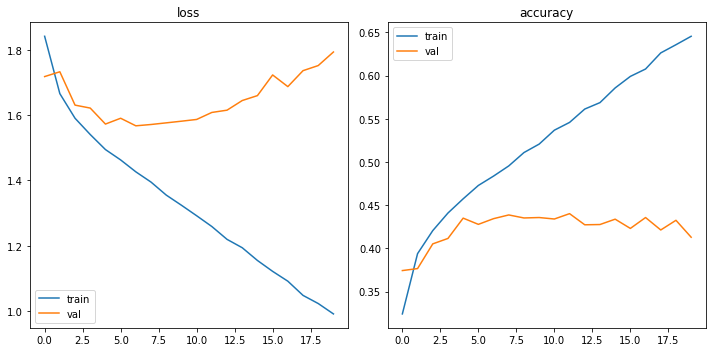

In [ ]:
#Визуализируем данные обучения

fig = plt.figure(tight_layout=True)

#задаем размерность сетки для размещения графиков
gs= fig.add_gridspec(1,2)
fig.set_size_inches(10, 5)

ax = fig.add_subplot(gs[0,0])
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'val')
        
#Добавление подписей на график
ax.set_title('loss')
ax.legend()

ax = fig.add_subplot(gs[0,1])
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'val')

ax.set_title('accuracy')
ax.legend()

plt.savefig(checkpoint_path.replace('.h5', '.png'))
plt.show()

## Тест модели

In [ ]:
# Загрузим модель
model = tf.keras.models.load_model(checkpoint_path)

#model.evaluate(val_generator)

In [ ]:
#загрузим названия классов
classes_names = []
with open(paths['class_names_path'], 'r') as f:
    classes_names = f.read().split(',')

In [ ]:
# выберем картинки для проверки
sample_cnt = 12

sample_img_paths = []
sample_img_labels = []
for i in range (sample_cnt):
    index = random.choice(range(0, len(val_generator.filepaths)))
    sample_img_paths.append (val_generator.filepaths[index])
    sample_img_labels.append (val_generator.labels[index])
    
#for

print (sample_img_paths)
print (sample_img_labels)

['/content/train/surprise/1035.jpg', '/content/train/happy/1870.jpg', '/content/train/fear/1218.jpg', '/content/train/surprise/1567.jpg', '/content/train/neutral/2024.jpg', '/content/train/anger/2109.jpg', '/content/train/contempt/1304.jpg', '/content/train/neutral/1932.jpg', '/content/train/neutral/1809.jpg', '/content/train/disgust/1009.jpg', '/content/train/anger/1748.jpg', '/content/train/neutral/1269.jpg']
[7, 4, 3, 7, 5, 0, 1, 5, 5, 2, 0, 5]


In [ ]:
#import importlib
#importlib.reload (utils)

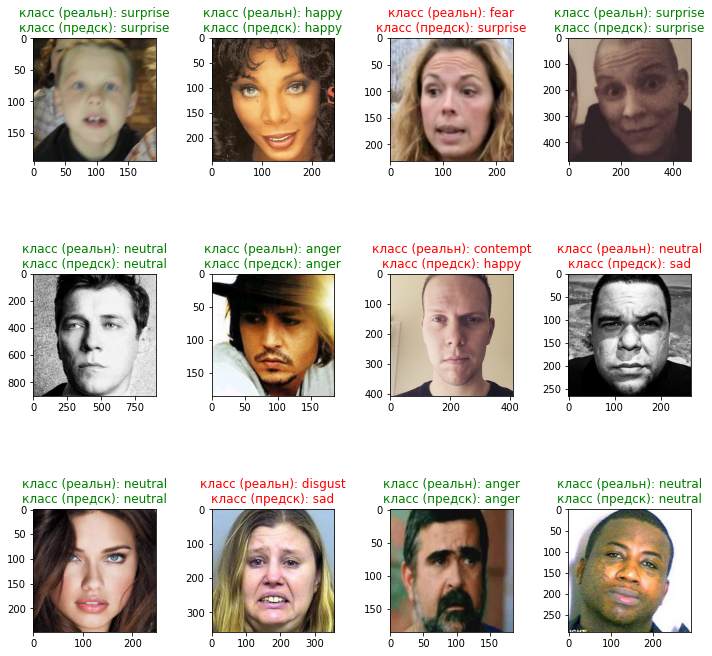

In [ ]:
# Тест предсказания

utils.test_model_prediction (p_model = model,
                             p_img_paths = sample_img_paths,
                             p_img_emo_idxs = sample_img_labels,
                             p_img_target_size = (IMAGE_SIZE, IMAGE_SIZE),
                             preprocess_func = preprocess_input,
                             p_emo_classes_names = classes_names)